In [33]:
# DB
from questions.models import Solution, Cluster
from evaluation.models import SolutionConcept, Intruder, TopicName
from django.db.models import Count

# Helpers
import operator
import pandas as pd
from tqdm import tqdm_notebook
from collections import defaultdict
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## Cleaning database
last_id = 132
problems = Problem.objects.filter(id__gt=last_id)
solutions_obj = Solution.objects.filter(problem__in=problems).update(ignore=True)
print("Problems to be ignored: %d" % problems.count())

problems = Problem.objects.filter(id__lte=last_id)
# problems = Problem.objects.all()
print("Problems to be used: %d" % problems.count())

solutions_obj = Solution.objects.filter(problem__in=problems, ignore=False).order_by('id')
# solutions_obj = Solution.objects.all().order_by('id')
print("Solutions to be used: %d" % solutions_obj.count())

docs_id = []
questions = []
solutions = []

# Fill separated structures
for sol in solutions_obj:
    docs_id.append(sol.id)
    questions.append(sol.problem.content)
    solutions.append(sol.content)

print("Got %d documents" %(solutions_obj.count()))

Problems to be ignored: 591
Problems to be used: 132
Solutions to be used: 54
Got 54 documents


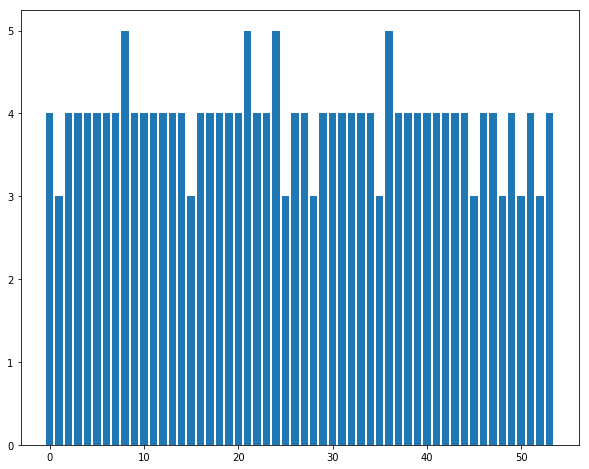

In [177]:
clusters = Cluster.objects.all()
solutions = Solution.objects.filter(ignore=False)
concepts = SolutionConcept.objects.all()
count = concepts.values_list('solution').annotate(count=Count('user', distinct=True))
x, y = zip(*list(count))
plt.figure(figsize=(10,8))
plt.bar(range(len(x)),y)
plt.show()

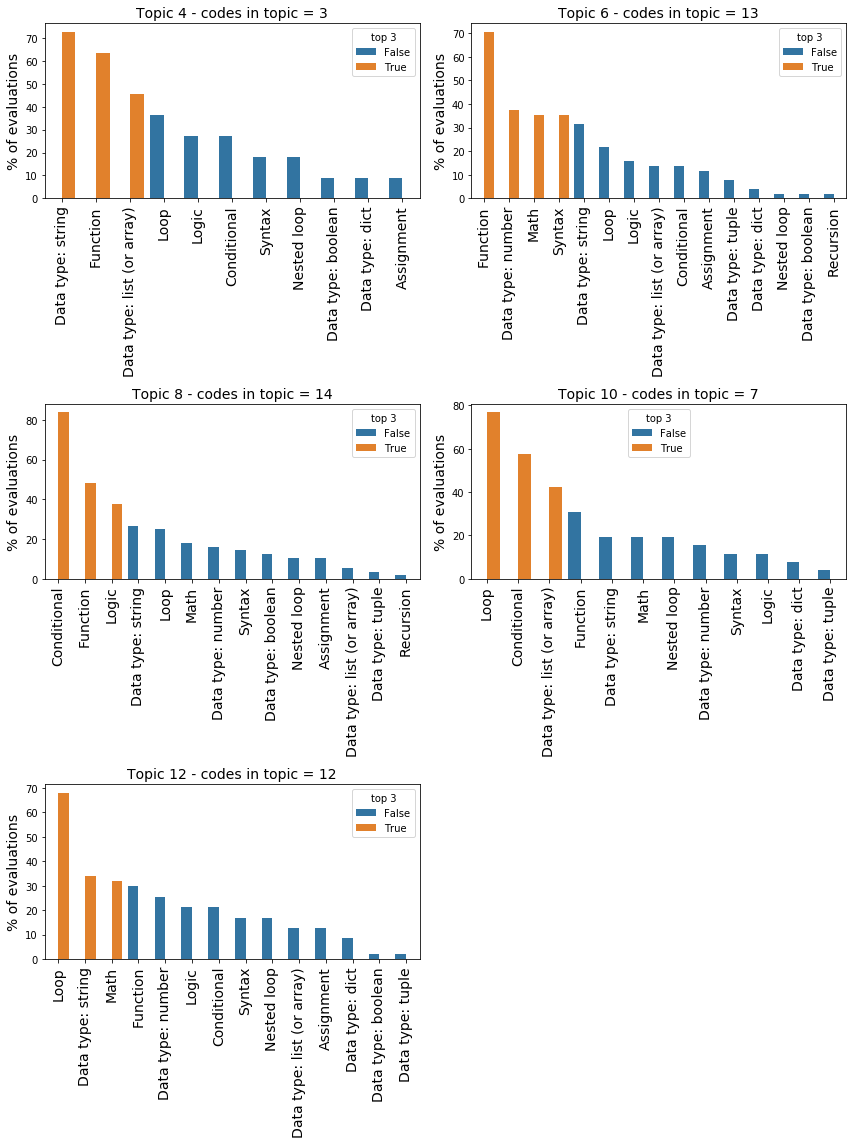

In [202]:
concept_solution = []
fig = plt.figure(figsize=(12,16))
for idx_cluster, cluster in enumerate(clusters):
    # Get solutions belonging to cluster
    solution_cluster = solutions.filter(cluster=cluster)
    
    # Get voted concepts
    concept_solution = concepts.filter(solution__in=solution_cluster)
    
    # Calculate max of points a concept can have
    user_count = concept_solution.values_list('solution').annotate(count=Count('user', distinct=True))
    max_points = sum(list(zip(*user_count))[1])
    
    # Count quantity of votes for each concept 
    count = list(concept_solution.values_list('concept__label').annotate(count=Count('concept')))
    count.sort(key=operator.itemgetter(1), reverse=True)
    
    # Transform to percentage and set threshold limit for top 3 results
    df = pd.DataFrame(count, columns=["concept", "count"])
    df['count'] = df.apply(lambda x: x["count"]/max_points*100, axis=1)
    threshold = df.nlargest(3, 'count').tail(1)['count'].tolist()[0]
    df['top 3'] = df.apply(lambda x: True if x["count"] >= threshold else False, axis=1)
    
    # Plot
    subplot = 321 + idx_cluster
    fig.add_subplot(subplot)
    plt.title("Topic %d - codes in topic = %d" % (cluster.id, solution_cluster.count()), fontsize=14)
    sns.barplot(x='concept', y='count', hue='top 3', data=df)
    plt.xticks(fontsize=14, rotation=90)
    plt.xlabel("")
    plt.ylabel("% of evaluations", fontsize=14)

plt.tight_layout()
plt.savefig("images/evaluation.png")
plt.savefig("images/evaluation.eps", format="eps")
plt.show()

In [96]:
# Scores
scores = defaultdict(dict)
clusters = list(Cluster.objects.all().values_list('id', flat=True).distinct().order_by('id'))
confusion = np.zeros((len(clusters), len(clusters)))
total = np.zeros((len(clusters), len(clusters)))

# Get all user and cluster combinations
user_cluster = Intruder.objects.all().values_list('user', 'cluster').distinct()

for uc in tqdm_notebook(user_cluster):
    # Get solution classified as intruder by the user for given cluster
    # There should be only one per group, so using get shouldn't raise any errors
    user_intruder = Intruder.objects.get(user=uc[0], cluster=uc[1], intruder=True)
    scores[user_intruder.cluster.label]["label"] = user_intruder.cluster.label
    
    # Get correct answers
    actual_intruder = Intruder.objects.exclude(solution__cluster__id=user_intruder.cluster.id).get(
        user=uc[0], cluster=uc[1])
    expected = clusters.index(actual_intruder.cluster.id)
    predicted = clusters.index(actual_intruder.solution.cluster.id)
    
    # If it's actually an intruder
    if user_intruder.cluster != user_intruder.solution.cluster:
        try:
            scores[user_intruder.cluster.label]["correct"] += 1
        except KeyError:
            scores[user_intruder.cluster.label]["correct"] = 1
    else:
        try:
            scores[user_intruder.cluster.label]["wrong"] += 1
        except KeyError:
            scores[user_intruder.cluster.label]["wrong"] = 1
            
        # Create confusion matrix (rows are correct, columns are inferred)
        confusion[expected, predicted] += 1
    
    # Count to compare number of 
    total[expected, predicted] += 1

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


In [102]:
confusion_percent = np.true_divide(confusion, total)
confusion_percent

/home/lmoraes/miniconda3/envs/machineteaching/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([[       nan, 0.5       , 0.5       , 0.66666667, 0.4       ],
       [       nan,        nan, 0.6       , 0.5       , 1.        ],
       [       nan, 0.14285714,        nan, 0.        , 0.33333333],
       [1.        , 0.5       , 0.2       ,        nan, 0.66666667],
       [0.        , 0.25      , 0.        , 1.        ,        nan]])

In [140]:
clusters = list(Cluster.objects.all().values_list('label', flat=True).distinct().order_by('id'))
confusion_df = pd.DataFrame(confusion_percent, columns=clusters, index=clusters)
confusion_df

,String manipulation,One-liners,Conditional,Array manipulation,Loops and nested loops
String manipulation,NaN,0.500000,0.5,0.666667,0.400000
One-liners,NaN,NaN,0.6,0.500000,1.000000
Conditional,NaN,0.142857,NaN,0.000000,0.333333
Array manipulation,1.0,0.500000,0.2,NaN,0.666667
Loops and nested loops,0.0,0.250000,0.0,1.000000,NaN


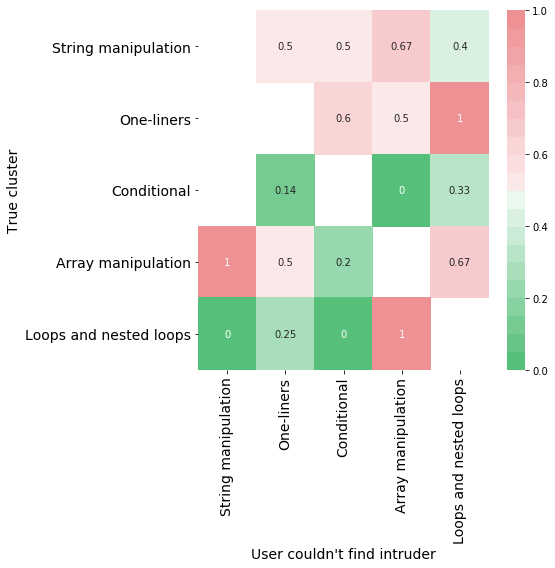

In [205]:
cmap = sns.diverging_palette(138, 10, l=70, n=20)
plt.figure(figsize=(8,8))
sns.heatmap(confusion_df, annot=True, cmap=cmap)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("User couldn't find intruder", fontsize=14)
plt.ylabel("True cluster", fontsize=14)
plt.tight_layout()
plt.savefig("images/confusion_matrix.png")
plt.savefig("images/confusion_matrix.eps", format="eps")
plt.show()

In [336]:
df = pd.DataFrame.from_dict(scores, orient='index')
df = df.sort_values('correct', ascending=False)

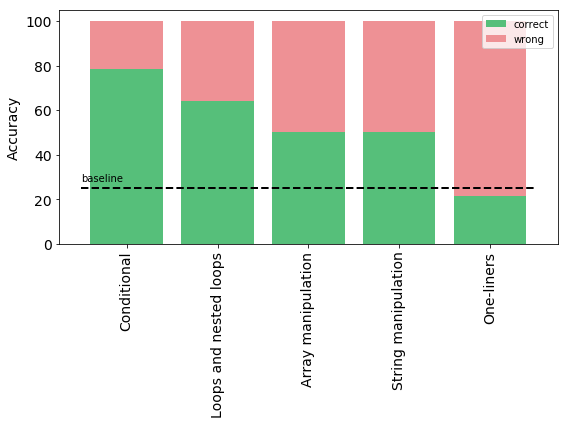

In [337]:
# From raw value to percentage
totals = [i+j for i,j in zip(df['correct'], df['wrong'])]
correctBars = [i / j * 100 for i,j in zip(df['correct'], totals)]
wrongBars = [i / j * 100 for i,j in zip(df['wrong'], totals)]

plt.figure(figsize=(8,6))
# Create correct Bars
plt.bar(df.index, correctBars, color=cmap[0], label="correct")
# Create wrong Bars
plt.bar(df.index, wrongBars, color=cmap[-1], bottom=correctBars, label="wrong")
# # Create blue Bars

plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend()

# Plot baseline
plt.plot([-0.5, 4.5], [25, 25], 'k--', lw=2)
plt.text(-0.5, 28, "baseline")

# Show graphic
plt.tight_layout()
plt.savefig("accuracy.png")
plt.savefig("accuracy.eps", format="eps")
plt.show()

In [311]:
from collections import Counter
from wordcloud import WordCloud

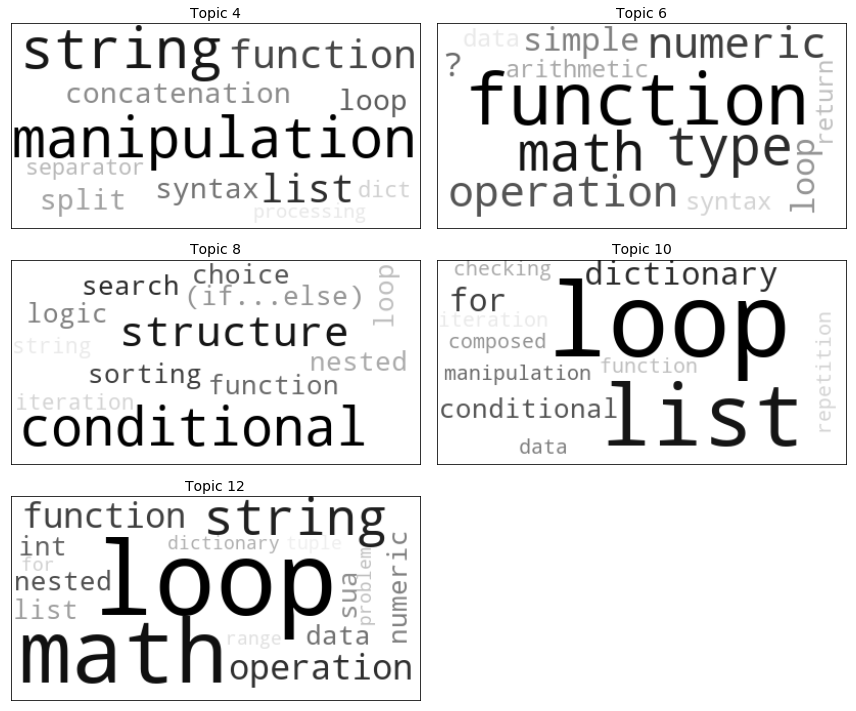

In [334]:
stopwords = ["de", "e", "em", "and", "sua", "com"]
en_pt = {
    "function": "funçõe",
    "math": "matemática",
    "list": "lista",
    "conditional": "condicional"
}
pt_en = {
    "funçõe": "function",
    "função": "function",
    "matemática": "math",
    "tipo": "type",
    "numérico": "numeric",
    "operaçõe": "operation",
    "aritmética": "arithmetic",
    "retorno": "return",
    "dado": "data",
    "manipulação": "manipulation",
    "lista": "list",
    "concatenação": "concatenation",
    "separadore": "separator",
    "processamento": "processing",
    "condicional": "conditional",
    "estrutura": "structure",
    "pesquisa": "search",
    "ordenação": "sorting",
    "iteração": "iteration",
    "aninhado": "nested",
    "dicionário": "dictionary",
    "composto": "composed",
    "laço": "loop",
    "repetição": "repetition"
}

cluster = TopicName.objects.all().values_list('cluster').distinct().order_by('cluster__id')
plt.figure(figsize=(12,10))
for idx_cluster,c in enumerate(cluster):
    names = TopicName.objects.filter(cluster=c)
    tokens = []
    for n in names:
        tmp_tokens = n.label.lower().replace(",","").split(" ")
        tmp_tokens = [t.strip() for t in tmp_tokens if t not in stopwords]
        tmp_tokens = [t.rstrip('s') for t in tmp_tokens if t not in stopwords]
        tmp_tokens = [pt_en[t] if t in pt_en.keys() else t for t in tmp_tokens]
        tokens += tmp_tokens
    c_tokens = Counter(tokens)
    sorted(c_tokens.items(), key = lambda x:x[1] , reverse=True)
    cs = list(zip(*sorted(c_tokens.items(), key = lambda x:x[1] , reverse=True)))[0]
    wc = WordCloud(background_color="white", max_words=1000, color_func=colormap_color_func("gray", frequencies=cs))
    # generate word cloud
    wc.generate_from_frequencies(c_tokens)
    # Plot
    ax= plt.subplot(3, 2 ,idx_cluster+1)
    ax.set_title("Topic %d" % c[0], fontsize=14)
    im = ax.imshow(wc, interpolation="bilinear")
    plt.tick_params(
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,
        right=False,
        labelbottom=False,
        labelleft=False)
#     ax.axis("off")
plt.tight_layout()
plt.savefig("images/topic_names.png")
plt.savefig("images/topic_names.eps", format="eps")
plt.show()

In [326]:
class colormap_color_func(object):
    """Color func created from matplotlib colormap.
    Parameters
    ----------
    colormap : string or matplotlib colormap
        Colormap to sample from
    Example
    -------
    >>> WordCloud(color_func=colormap_color_func("magma"))
    """
    def __init__(self, colormap, frequencies):
        import matplotlib.pyplot as plt
        self.colormap = plt.cm.get_cmap(colormap, len(frequencies))
        self.frequencies = frequencies

    def __call__(self, word, font_size, position, orientation,
                 random_state=None, **kwargs):
        
        idx = list(self.frequencies).index(word)
        r, g, b, _ = np.maximum(0, 255 * np.array(self.colormap(idx)))
        return "rgb({:.0f}, {:.0f}, {:.0f})".format(r, g, b)